In [1]:
# ライブラリ読み込み
import pandas as pd
import codecs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [ ]:
# メモリ削減
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [2]:
# csvを読み込みデータフレームに変換
df = {}
with codecs.open("../data/input/JPvideos.csv", "r", "utf-8", "ignore") as file:
    df = pd.read_table(file, delimiter=",")

In [7]:
colomns = list(df.columns)
for c in colomns:
    print(c)
print(len(colomns))

video_id
trending_date
title
channel_title
category_id
publish_time
tags
views
likes
dislikes
comment_count
thumbnail_link
comments_disabled
ratings_disabled
video_error_or_removed
description
16


In [8]:
print(df.shape)

(20523, 16)


In [9]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
categorical_feats = df.dtypes[df.dtypes == "object"].index

In [10]:
numerical_feats

Index(['category_id', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed'],
      dtype='object')

In [11]:
categorical_feats

Index(['video_id', 'trending_date', 'title', 'channel_title', 'publish_time',
       'tags', 'thumbnail_link', 'description'],
      dtype='object')

## 欠損地の確認

In [12]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
description,2124,0.103494
video_error_or_removed,0,0.000000
ratings_disabled,0,0.000000
comments_disabled,0,0.000000
thumbnail_link,0,0.000000
comment_count,0,0.000000
dislikes,0,0.000000
likes,0,0.000000
views,0,0.000000
tags,0,0.000000


## Numerical Features

In [13]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,20523.000000,2.052300e+04,2.052300e+04,20523.000000,20523.000000
mean,19.807533,2.620215e+05,8.059587e+03,366.823613,1196.077864
std,6.655895,1.294938e+06,8.384837e+04,2658.598540,14943.608305
min,1.000000,7.980000e+02,0.000000e+00,0.000000,0.000000
25%,17.000000,1.710000e+04,1.210000e+02,9.000000,19.000000
50%,22.000000,6.408400e+04,6.480000e+02,43.000000,133.000000
75%,24.000000,1.833670e+05,2.303000e+03,178.000000,488.000000
max,29.000000,6.279639e+07,4.470923e+06,119053.000000,905925.000000


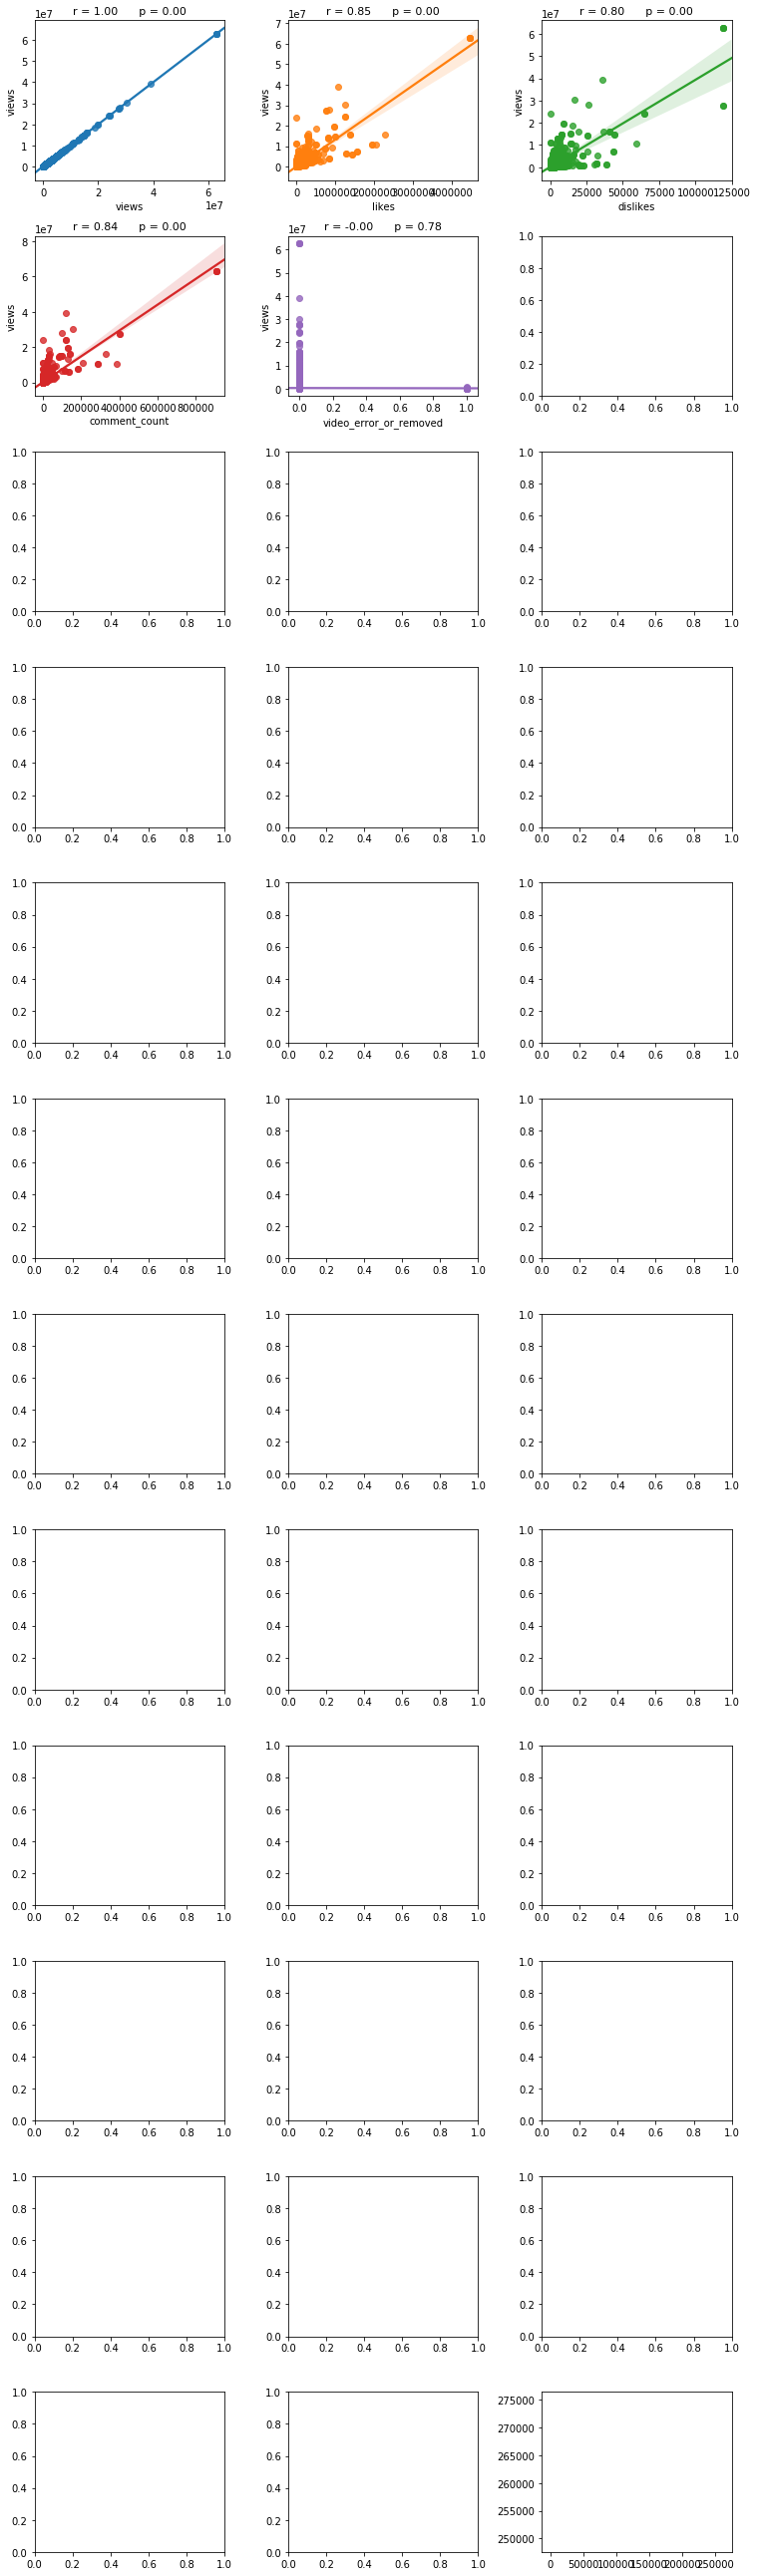

In [16]:
nr_rows = 12 #図を表示する際の行数
nr_cols = 3 #図を表示する際の列数
#nr_rows * nr_colsがカラム数を超えるように設定。

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ["category_id", "comments_disabled", "ratings_disabled"]
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]
target = "views"

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[i]], df[target], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[i]], df[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)

plt.tight_layout()    
plt.show()  

上記より、目的変数であるviewsの説明変数は、likes、dislikes、comment_countであることが分かる

## Categorical Feature

In [17]:
for catg in list(categorical_feats) :
    print(df[catg].value_counts())
    print('#'*50)

#NAME?         282
5ugKfHgsmYw      8
geOSYId6tac      8
KqtWo-4A0LU      8
upEDdoizZNM      6
              ... 
GbFQeyMX3Sc      1
NqMZQEhkPn4      1
sAVff3i5ZTk      1
QjI8qSaZa5Q      1
5FuP1Jjujfo      1
Name: video_id, Length: 12912, dtype: int64
##################################################
18.28.04    199
18.04.04    199
18.04.05    199
18.26.04    198
18.15.05    197
           ... 
18.07.02    128
18.28.03    102
18.19.05     92
18.20.05     56
18.15.03     40
Name: trending_date, Length: 122, dtype: int64
##################################################
【吹いたら負け】話題の面白い画像集                                                     17
リクエストを即興で弾き語ります！！！                                                    14
陸自ヘリ、垂直に落下＝路上の車が撮影                                                     8
西城秀樹の訃報を江原啓之が予言していた事実が発覚！１０年前の霊視で見えた内容とは？                              8
【最強の飯テロ】絶対に深夜に見ないでください。                                                7
                                                         

In [ ]:
li_cat_feats = list(categorical_feats)
nr_rows = 15 #図を表示する際の行数
nr_cols = 3 #図を表示する際の列数
#nr_rows * nr_colsがカラム数を超えるように設定。

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df, ax = axs[r][c])

plt.tight_layout()    
plt.show()  